<a href="https://colab.research.google.com/github/Chigaga/space_weather/blob/main/reprojection_aia_euvi_for_full_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Creating a Full Sun Map with AIA and EUVI

With SDO/AIA and STEREO/A and STEREO/B, it is now possible (given specific dates)
to combine combine three EUV images from these satellites
to produce a full latitude / longitude map of the Sun.

Need an active internet connection as well as
`reproject <https://reproject.readthedocs.io/en/stable/>`__ v0.6 or higher installed.


In [ ]:
!pip install sunpy
!pip install astropy
!pip install reproject

In [ ]:
!pip install zeep
!pip install drms

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

import sunpy.map
import sunpy.sun
from sunpy.coordinates import get_body_heliographic_stonyhurst
from sunpy.net import Fido
from sunpy.net import attrs as a

To get started, let's download the data:



In [ ]:
stereo = (a.Instrument("EUVI") &
          a.Time('2011-11-01', '2011-11-01T00:10:00'))
aia = (a.Instrument.aia &
       a.Sample(24 * u.hour) &
       a.Time('2011-11-01', '2011-11-02'))
wave = a.Wavelength(19.5 * u.nm, 19.5 * u.nm)
res = Fido.search(wave, aia | stereo)
files = Fido.fetch(res)

Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

20111101_000530_n4eua.fts:   0%|          | 0.00/8.41M [00:00<?, ?B/s]

20111101_000530_n4eub.fts:   0%|          | 0.00/8.41M [00:00<?, ?B/s]

aia_lev1_193a_2011_11_01t00_00_07_84z_image_lev1.fits:   0%|          | 0.00/12.7M [00:00<?, ?B/s]

Next we create a sunpy map for each of the files.



In [ ]:
maps = sunpy.map.Map(sorted(files))

To reduce memory consumption we also downsample these maps before continuing,
you can disable this.



In [ ]:
maps = [m.resample((1024, 1024)*u.pix) for m in maps]

When combining these images all three need to assume the same radius of
the Sun for the data. The AIA images specify a slightly different value
than the IAU 2015 constant. To avoid coordinate transformation issues we
reset this here.



In [ ]:
maps[0].meta['rsun_ref'] = sunpy.sun.constants.radius.to_value(u.m)

Next we will plot the locations of the three spacecraft with respect to
the Sun so we can easily see the relative separations.



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


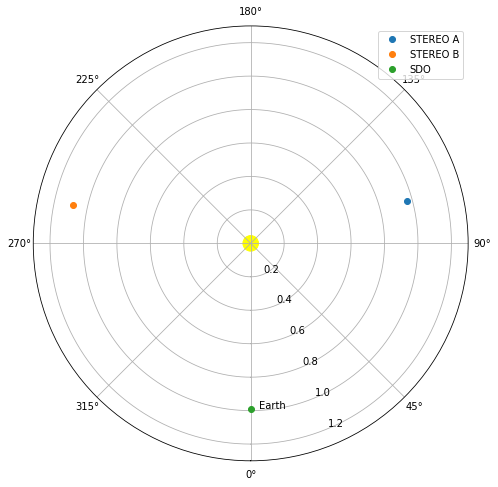

In [ ]:
earth = get_body_heliographic_stonyhurst('earth', maps[0].date)

plt.figure(figsize=(8, 8))
r_unit = u.AU

ax = plt.subplot(projection='polar')
circle = plt.Circle((0.0, 0.0), (10*u.Rsun).to_value(r_unit),
                    transform=ax.transProjectionAffine + ax.transAxes, color="yellow",
                    alpha=1, label="Sun")
ax.add_artist(circle)
ax.text(earth.lon.to_value("rad")+0.05, earth.radius.to_value(r_unit), "Earth")

for this_satellite, this_coord in [(m.observatory, m.observer_coordinate) for m in maps]:
    ax.plot(this_coord.lon.to('rad'), this_coord.radius.to(r_unit), 'o', label=this_satellite)

ax.set_theta_zero_location("S")
ax.set_rlim(0, 1.3)

ax.legend()

plt.show()

The next step is to calculate the output coordinate system for the combined
map. We select a heliographic Stonyhurst frame, and a Plate Carree (CAR)
projection, and generate a header using `sunpy.map.make_fitswcs_header` and
then construct a World Coordinate System (WCS) object for that header.



In [ ]:
shape_out = (180, 360)  # This is set deliberately low to reduce memory consumption
header = sunpy.map.make_fitswcs_header(shape_out,
                                       SkyCoord(0, 0, unit=u.deg,
                                                frame="heliographic_stonyhurst",
                                                obstime=maps[0].date),
                                       scale=[360 / shape_out[1],
                                              180 / shape_out[0]] * u.deg / u.pix,
                                       wavelength=int(maps[0].meta['wavelnth']) * u.AA,
                                       projection_code="CAR")
out_wcs = WCS(header)

Next we call the `reproject.mosaicking.reproject_and_coadd` function, which
takes a list of maps, and the desired output WCS and array shape.



In [ ]:
array, footprint = reproject_and_coadd(maps, out_wcs, shape_out,
                                       reproject_function=reproject_interp)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


To display the output we construct a new map using the new array and our
generated header. We also borrow the plot settings from the AIA map.



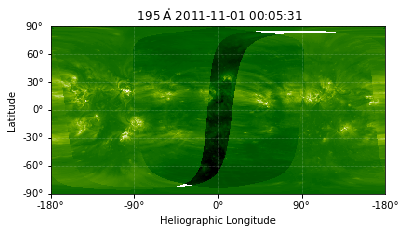

In [ ]:
outmap = sunpy.map.Map((array, header))
outmap.plot_settings = maps[0].plot_settings
outmap.plot()

plt.show()

## Improving the Output

As you can see this leaves a little to be desired. To reduce the obvious
warping towards the points which are close to the limb in the input
images, we can define a set of weights to use when co-adding the output
arrays. To reduce this warping we want to calculate an set of weights
which highly weigh points close to the centre of the disk in the input
image.

We can achieve this by using sunpy's coordinate framework. First we
calculate all the world coordinates for all the pixels in all three
input maps.



In [ ]:
coordinates = tuple(map(sunpy.map.all_coordinates_from_map, maps))

To get a weighting which is high close to disk centre and low towards
the limb, we can use the Z coordinate in the heliocentric frame. This
coordinate is the distance of the sphere from the centre of the Sun
towards the observer.



In [ ]:
weights = [coord.transform_to("heliocentric").z.value for coord in coordinates]

These weights are good, but they are better if the ramp down is a little
smoother, and more biased to the centre. Also we can scale them to the
range 0-1, and set any off disk (NaN) regions to 0.



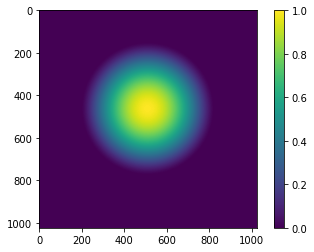

In [ ]:
weights = [(w / np.nanmax(w)) ** 3 for w in weights]
for w in weights:
    w[np.isnan(w)] = 0

plt.figure()
plt.imshow(weights[0])
plt.colorbar()

plt.show()

Now we can rerun the reprojection. This time we also set
``match_background=True`` which scales the images by a single scaling
factor so they are of similar brightness. We also set
``background_reference=0`` which uses the AIA map as the reference for
the background scaling.

Here we are using the fastest but least accurate method of reprojection,
`reproject.reproject_interp`, a more accurate but slower method is
`reproject.reproject_adaptive`.



In [ ]:
array, _ = reproject_and_coadd(maps, out_wcs, shape_out,
                               input_weights=weights,
                               reproject_function=reproject_interp,
                               match_background=True,
                               background_reference=0)

Once again we create a new map, and this time we customise the plot a
little.



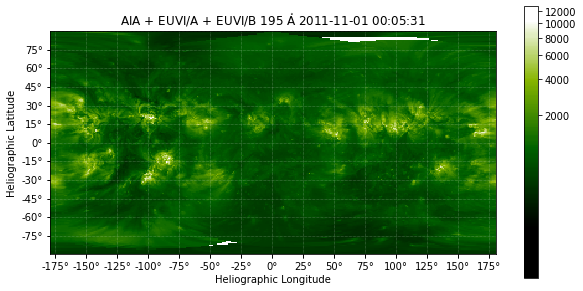

In [ ]:
outmap = sunpy.map.Map((array, header))
outmap.plot_settings = maps[0].plot_settings
outmap.nickname = 'AIA + EUVI/A + EUVI/B'

plt.figure(figsize=(10, 5))
ax = plt.subplot(projection=out_wcs)
im = outmap.plot(vmin=400)

lon, lat = ax.coords
lon.set_coord_type("longitude")
lon.coord_wrap = 180
lon.set_format_unit(u.deg)
lat.set_coord_type("latitude")
lat.set_format_unit(u.deg)

lon.set_axislabel('Heliographic Longitude', minpad=0.8)
lat.set_axislabel('Heliographic Latitude', minpad=0.9)
lon.set_ticks(spacing=25*u.deg, color='k')
lat.set_ticks(spacing=15*u.deg, color='k')

plt.colorbar(im, ax=ax)

# Reset the view to pixel centers
_ = ax.axis((0, shape_out[1], 0, shape_out[0]))

plt.show()